# Optimization
You can use the Optimize module to automatically tune experimental parameters to minimize any function you define. You can also easily define sequences of optimizations - for example, we could do a coarse grid search to obtain an initial signal, then shrink the bounds to enclose the signal and sample with higher resolution, then finally fit all observed data to a model which predicts the location of the maximum. 

The beauty of this module is that it can be run entirely outside of EMERGENT, e.g. to optimize any Python function, and the interface with the Core module simply consists of using an Experiment as this function. This makes it easy to interface this module with your own lab code (or even to optimize your simulations), even if you're not using EMERGENT to control your devices!

As a basic example, we'll define a simple function and optimize it by brute force grid search (refer to the "Optimizer blocks" section for more sophisticated examples).

In [1]:
''' This block is automatically run every time the kernel is restarted! '''
from emergent.pipeline import *

''' Define function to minimize '''
import numpy as np
def cost(state, params = {'sigma_x': 0.3, 'sigma_y': 0.8, 'x0': 0.3, 'y0': 0.6, 'noise':0.0}):
    return -np.exp(-(state['X']-params['x0'])**2)*np.exp(-(state['Y']-params['y0'])**2)


The cost function should have two arguments. The "state" is a dictionary containing the independent variables, and the "params" is a dictionary containing parameters defining the cost evaluation - in this case, 'x0' and 'y0' define the center position of a multivariate Gaussian. The pipeline will minimize the cost function, so make sure you set the sign of the return value appropriately.

Now let's define our initial state and the bounds:

In [2]:
''' This block is automatically run every time the kernel is restarted! '''
state = {'X': 0, 'Y': 0}
bounds = {'X': (-3,3), 'Y': (-3,3)}

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 102
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.930324
INFO:root:Improvement: 45.9%


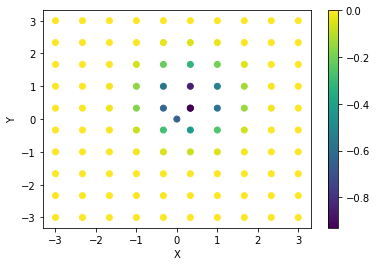

In [19]:
search=GridSearch({'Steps': 10}, state, bounds, cost)
search.plot()

# Pipelines

More complicated optimizations are handled through Pipelines. Let's try repeating the previous example. We instantiate the pipeline object, add a GridSearch block, and run the pipeline:

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 102
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.930324
INFO:root:Improvement: 45.9%


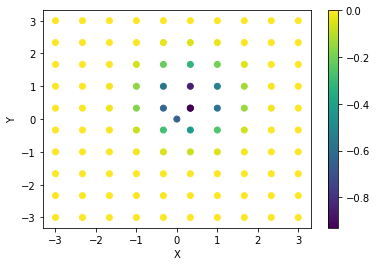

In [20]:
pipe = Pipeline(state, bounds, cost)
pipe.add(GridSearch({'Steps': 10}))
points, costs = pipe.run()
pipe.plot()

This basic grid search does alright for low dimensional problems. However, as the dimensionality of the parameter space grows, the number of iterations required grows exponentially! A coarse 10-point-per-axis grid search in six dimensions would take a million iterations to complete!

For optimization in higher dimensions, a number of other algorithms are included. I will demonstrate these in the following examples.

## Optimizing substates
Imagine that we have a function that takes variables X, Y, and Z and we want to optimize the first while holding the two at a constant value. To do so, we can pass a dict into the "substate" keyword argument of the Pipeline class corresponding only to the variables we want to change.

Compare the following two cases: in the first, we hold one variable constant and in the second we search over both variables.

In [22]:
from emergent.pipeline import *
pipe = Pipeline(state, bounds, cost, substate = {'X': 0.1})
pipe.add(GridSearch())
points, costs = pipe.run()


INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 22
INFO:root:Initial cost: -0.670320
INFO:root:Final cost: -0.683729
INFO:root:Improvement: 2.0%


In [23]:
pipe = Pipeline(state, bounds, cost)
pipe.add(GridSearch())
points, costs = pipe.run()

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 402
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.964496
INFO:root:Improvement: 51.3%


# Optimizer blocks
## Gradient-based methods
The grid search is inefficient because all of the sampled points are chosen before starting the optimization. In many cases, the minimum can be found more efficiently by choosing each subsequent point based on knowledge of the parameter space. 

### Gradient descent
The simplest way to do this is to measure the local gradient, take a step downhill, and repeat. This is implemented by the GradientDescent algorithm - let's try it out. We'll rebuild the pipeline from scratch, but make sure you've run the above blocks in the current kernel to define the cost function, initial state, and bounds.

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 101
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -1.000000
INFO:root:Improvement: 56.8%


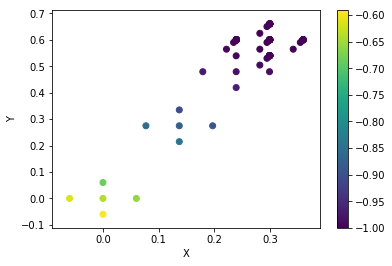

In [24]:
from emergent.pipeline import Pipeline, GradientDescent

pipe = Pipeline(state, bounds, cost)
pipe.add(GradientDescent({'Learning rate': 1e-2, 'Iterations':20}))
points, costs = pipe.run()
pipe.plot()

The GradientDescent comes about as close to the local minimum in half the experimental iterations of the GridSearch method, and the relative performance should increase in higher dimensional parameter spaces.

### L-BFGS-B
The L-BFGS-B algorithm is another option, tending to perform excellently in low dimensional spaces:

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 16
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.999897
INFO:root:Improvement: 56.8%


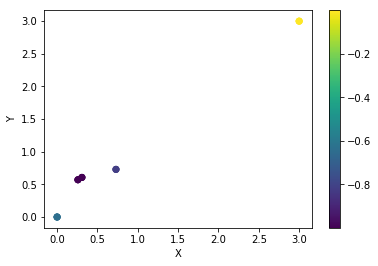

In [25]:
from emergent.pipeline import Pipeline, LBFGSB
pipe = Pipeline(state, bounds, cost)
pipe.add(LBFGSB())
points, costs = pipe.run()
pipe.plot()

### Adam
Lastly, the Adam optimizer incorporates momentum to more efficiently navigate valleys and saddle points. 

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 185
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.991046
INFO:root:Improvement: 55.4%


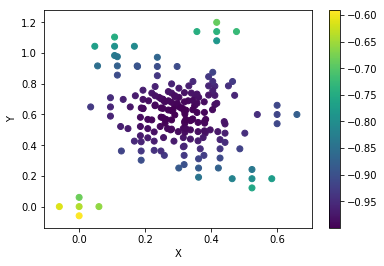

In [26]:
pipe = Pipeline(state, bounds, cost)
pipe.add(Adam())
points, costs = pipe.run()
pipe.plot()

## Stochastic methods
Gradient-based methods can be inefficient for several reasons:
* High-dimensional parameter spaces often have many local minima where the optimizer will get trapped.
* Measurement noise will degrade the gradient accuracy, which can cause the optimizer to move in the wrong direction or get stuck in regions where the noise is larger than the local gradient
* Gradient computations in N dimensions require 2N function evaluations, which can take a while.

An alternative is to use semi-random methods where samples are generated based on knowledge of other samples. 

### Differential evolution
The DifferentialEvolution algorithm creates a population of points and carries out generations of "breeding" to select for regions of parameter space where the cost function is low:

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 573
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -1.000000
INFO:root:Improvement: 56.8%


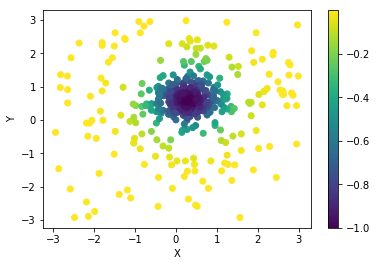

In [27]:
from emergent.pipeline import Pipeline, DifferentialEvolution

pipe = Pipeline(state, bounds, cost)
pipe.add(DifferentialEvolution())
points, costs = pipe.run()
pipe.plot()

### Particle swarm
The ParticleSwarm optimizer similarly initializes a random set of particles which move through space to seek both their best known position and the best known position of the swarm. Note: this optimizer currently does not respect bounds.

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 212
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.987588
INFO:root:Improvement: 54.9%


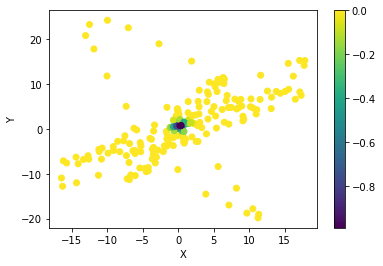

In [28]:
from emergent.pipeline import Pipeline, ParticleSwarm

pipe = Pipeline(state, bounds, cost)
pipe.add(ParticleSwarm({'Steps': 20}))
points, costs = pipe.run()
pipe.plot()

# Utility blocks



## Rescale
The Rescale block allows you to zoom in to enclose a region bounding only signals within a defined threshold from the observed best. This allows resizing of bounds after a coarse search to find initial signal.

## Prune
The training time of a model increases with the number of points, sometimes aggressively (e.g. O(N^3) for Gaussian processes). Experiments may accumulate a lot of "junk" points with little signal which add training time but are not particularly useful to the model. By adding a Prune block, you can discard any points with signal below a threshold relative to the best observed.

## Loop
To loop over a series of actions, you can create a Loop block and attach some other blocks to it. In the following example, we do the following three times:
1. Run a 10-step grid search.
2. Shrink the bounds to include only points within 50% of the best observed cost.

INFO:root:Optimization complete!
INFO:root:Time: 0s
INFO:root:Evaluations: 304
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.996371
INFO:root:Improvement: 56.3%


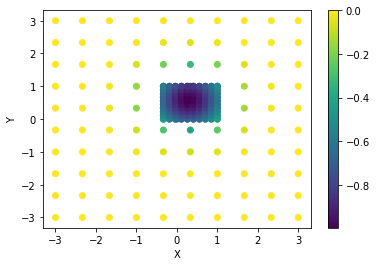

In [29]:
from emergent.pipeline import *     

pipe = Pipeline(state, bounds, cost)

loop = pipe.add(Loop({'Loops': 3}))
loop.add(GridSearch({'Steps': 10}))      ## acquire initial data with a coarse grid search
loop.add(Rescale({'Threshold': 0.5}))
    
points, costs = pipe.run()      # run through all attached blocks, including the model subpipeline
pipe.plot()

# Model subpipelines
Online optimization is a powerful strategy, especially for expensive, black-box cost functions. The basic idea is to form a closed loop consisting of:
1. Fit a parameter surface to observed data.
2. Numerically optimize the modeled surface to generate the next point.
3. Repeat until convergence.

Models are implemented as subpipelines which consume real data from the primary pipeline to train, then run through a set of user-defined blocks to numerically optimize the modeled surface:

INFO:root:Optimization complete!
INFO:root:Time: 3s
INFO:root:Evaluations: 107
INFO:root:Initial cost: -0.637628
INFO:root:Final cost: -0.930324
INFO:root:Improvement: 45.9%


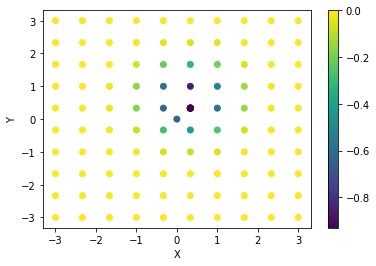

In [10]:
from emergent.pipeline import *     

pipe = Pipeline(state, bounds, cost)
pipe.add(GridSearch({'Steps': 10}))      ## acquire initial data with a coarse grid search
loop = pipe.add(Loop({'Loops': 5}))
model = loop.add(GaussianProcess())       # attach a model subpipeline
grad = model.add(ParticleSwarm())            # run gradient descent to optimize the modeled surface
points, costs = pipe.run()      # run through all attached blocks, including the model subpipeline
pipe.plot()

# Pipeline persistence

After designing an optimization pipeline that works for your experiment, you'll probably want to save and load it. Pipelines can be represented in JSON serializable format through the Pipeline.to_json() method, and you can load from JSON using the Pipeline.from_json() method. Note: this method appends blocks to the current pipeline rather than loading into a fresh pipeline.

In [30]:
pipe.from_json([{'name': 'GridSearch'}])
pipe.to_json()

[{'name': 'Loop',
  'params': {'Loops': 3},
  'subblocks': [{'name': 'GridSearch', 'params': {'Steps': 10, 'Sweeps': 1}},
   {'name': 'Rescale', 'params': {'Threshold': 0.5}}]},
 {'name': 'GridSearch', 'params': {'Steps': 20, 'Sweeps': 1}}]

You can also save and load pipelines with the save() and load() methods.

# Meta-optimization
Beyond solving optimization problems, EMERGENT can also learn to solve these problems more efficiently through automated hyperparameter tuning. For example, consider the problem of tuning the learning rate in the Adam algorithm. Too small and the algorithm will converge slowly; too large and the algorithm will overshoot the peak. For each problem it is useful to tune the hyperparameters to maximize the rate of improvement during optimization.

Since meta-optimization is so important to achieve good results, you can do it within the Pipeline framework itself! By calling the Block.tune() method on any optimizer block attached to a pipeline, you can run a grid search over hyperparameter values and calculate the average improvement per iteration for each value. Note that, regardless of your objective function, this meta-optimization will often yield very noisy results, so it's recommended to stick to grid search and manual inspection rather than using fancier algorithms for the meta-optimization.

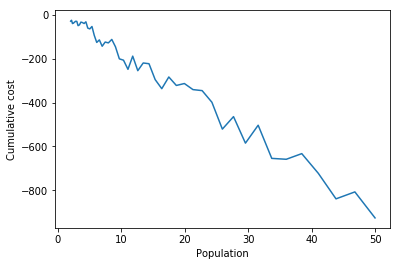

In [4]:
from emergent.pipeline import *
pipe = Pipeline(state, bounds, cost, verbose=False)
pipe.add(DifferentialEvolution())
block = pipe.blocks[0]
block.tune('Population', (2,50), steps=50, mode='cumulative')

If you had passed an experiment to the pipeline instead of our generic cost function, the Pipeline would have optimized your experiment repeatedly in order to identify the hyperparameters which most optimally solve the problem.